In [ ]:
import os
import sys
import copy
import random
import json
import yaml
import glob
import cv2
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from   zipfile import ZipFile
%matplotlib inline
import pandas as pd
import logging
import torch

# Set up logging
logging.basicConfig(level=logging.INFO)


In [ ]:
def download_and_unzip(url, save_path, extract_dir):
    print("Downloading assets...")
    file = requests.get(url)

    open(save_path, "wb").write(file.content)
    print("Download completed.")

    try:
        if save_path.endswith(".zip"):
            with ZipFile(save_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            print("Extraction Done")
    except Exception as e:
        print(f"An error occurred: {e}")

def download_image(url):
    filename = os.path.basename(url)

    response = requests.get(url)
    response.raise_for_status()

    with open(filename, 'wb') as file:
        file.write(response.content)

    return os.path.abspath(filename)

def get_basename(path):
  return os.path.basename(path)

def print_fish_data(fish_data):
    for idx, fish in enumerate(fish_data, start=1):
        print(f"ID: {idx}")
        print(f"Name: {fish['name']}")
        print(f"Species ID: {fish['species_id']}")
        print(f"Distance: {fish['distance']:.3f}")
        print(f"Accuracy: {fish['accuracy']:.2%}")
        print("-" * 40)


In [ ]:
# Links to models
MODEL_URLS = {
    'classification': 'https://storage.googleapis.com/fishial-ml-resources/classification_rectangle_v7-1.zip',
    'segmentation': 'https://storage.googleapis.com/fishial-ml-resources/segmentator_fpn_res18_416_1.zip',
    'detection': 'https://storage.googleapis.com/fishial-ml-resources/detector_v10_m3.zip',
    'face': 'https://storage.googleapis.com/fishial-ml-resources/face_yolo.zip'
}

# Model directories
MODEL_DIRS = {
    'classification': "models/classification",
    'segmentation': "models/segmentation",
    'detection': "models/detection",
    'face': "models/face_detector"
}

# Create directories and download models
for model_name, url in MODEL_URLS.items():
    model_dir = MODEL_DIRS[model_name]
    zip_path = os.path.join(os.getcwd(), get_basename(url))

    os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
    download_and_unzip(url, zip_path, model_dir)  # Download and unzip the model

    # Remove the zip file after extraction
    try:
        os.remove(zip_path)
        logging.info(f"Removed zip file {zip_path}")
    except Exception as e:
        logging.error(f"Failed to remove zip file {zip_path}: {e}")

Download completed.
Extraction Done
Download completed.
Extraction Done
Download completed.
Extraction Done
Download completed.
Extraction Done


In [ ]:
from models.classification.inference import EmbeddingClassifier
from models.detection.inference import YOLOInference
from models.segmentation.inference import Inference
from models.face_detector.inference import YOLOInference as FaceInference


# Model initialization
classifier = EmbeddingClassifier(
    os.path.join(MODEL_DIRS['classification'], 'model.ts'),
    os.path.join(MODEL_DIRS['classification'], 'database.pt')
)

segmentator = Inference(
    model_path=os.path.join(MODEL_DIRS['segmentation'], 'model.ts'),
    image_size=416
)

detector = YOLOInference(
    os.path.join(MODEL_DIRS['detection'], 'model.ts'),
    imsz=(640, 640),
    conf_threshold=0.9,
    nms_threshold=0.3,
    yolo_ver='v10'
)

face_detector = FaceInference(
    os.path.join(MODEL_DIRS['face'], 'model.ts'),
    imsz=(640, 640),
    conf_threshold=0.69,
    nms_threshold=0.5,
    yolo_ver='v8'
)

In [ ]:
import shutil
import os

output_dir = "processed_images"
zip_filename = "processed_fish_images.zip"

# Create a zip archive of the output directory
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', output_dir)

print(f"Created zip file: {zip_filename}")

Created zip file: processed_fish_images.zip


In [ ]:
from google.colab import files

# Download the zip file
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# You can change link below to your image with fish
url = 'https://www.mdpi.com/fishes/fishes-08-00514/article_deploy/html/images/fishes-08-00514-g001.png'
url_face = 'https://www.online-tech-tips.com/wp-content/uploads/2022/02/faces.jpeg'
face_path = download_image(url_face)
fish_path = download_image(url)

In [ ]:
from google.colab import files
from zipfile import ZipFile
import os

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  zip_path = fn

extract_dir = "extracted_images"
os.makedirs(extract_dir, exist_ok=True)

try:
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction completed to {extract_dir}")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

KeyboardInterrupt: 

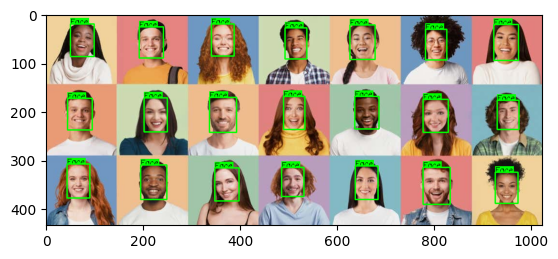

In [ ]:
face_bgr_np = cv2.imread(face_path)
face_rgb_np = cv2.cvtColor(face_bgr_np, cv2.COLOR_BGR2RGB)

face_boxes = face_detector.predict(face_rgb_np)[0]

for box in face_boxes:
  box.draw_label(face_rgb_np, "Face")
  box.draw_box(face_rgb_np)
plt.imshow(face_rgb_np)
plt.show()

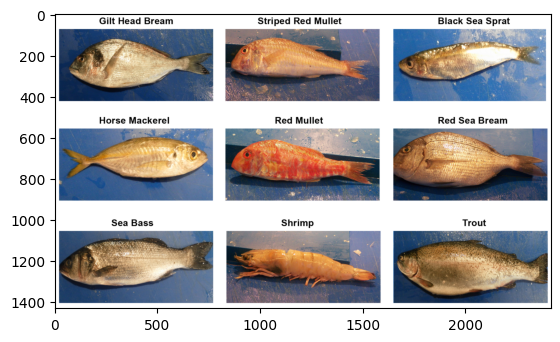

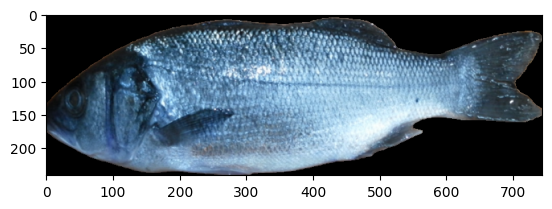

ID: 1
Name: Dicentrarchus labrax
Species ID: ad47b753-df73-46a3-8b2b-810c9ac146a4
Distance: 1.000
Accuracy: 100.00%
----------------------------------------


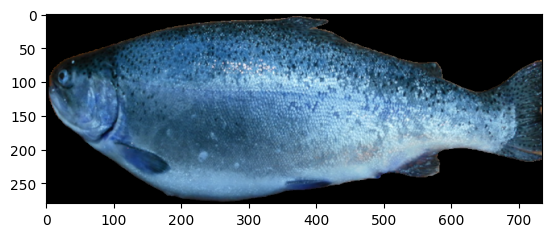

ID: 1
Name: Oncorhynchus mykiss
Species ID: c0ae3480-8f0a-4785-9098-9d8b6b294df9
Distance: 0.898
Accuracy: 100.00%
----------------------------------------


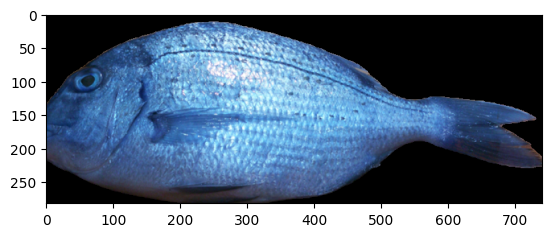

ID: 1
Name: Stenotomus chrysops
Species ID: b3d63981-9c0c-4f8d-9b38-d086413eaa48
Distance: 0.596
Accuracy: 53.33%
----------------------------------------
ID: 2
Name: Pagrus pagrus
Species ID: f19b07ae-1490-48f8-aac5-67df9411d4b6
Distance: 0.760
Accuracy: 26.67%
----------------------------------------
ID: 3
Name: Sparus aurata
Species ID: 940aef43-7ccd-40b7-b478-aa2ccb97c4c2
Distance: 0.686
Accuracy: 6.67%
----------------------------------------
ID: 4
Name: Pagrus auratus
Species ID: b20e2c34-45da-4512-8be1-ee55e3ed9dc2
Distance: 0.555
Accuracy: 6.67%
----------------------------------------
ID: 5
Name: Spondyliosoma cantharus
Species ID: f76f6958-e309-4990-a8f3-1d8b96f0810f
Distance: 0.550
Accuracy: 6.67%
----------------------------------------


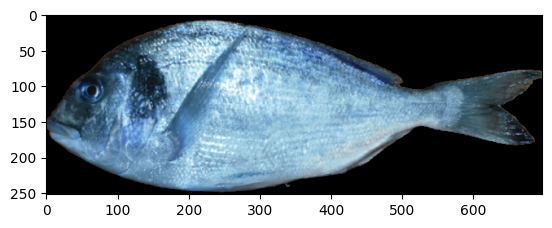

ID: 1
Name: Sparus aurata
Species ID: 940aef43-7ccd-40b7-b478-aa2ccb97c4c2
Distance: 0.940
Accuracy: 100.00%
----------------------------------------


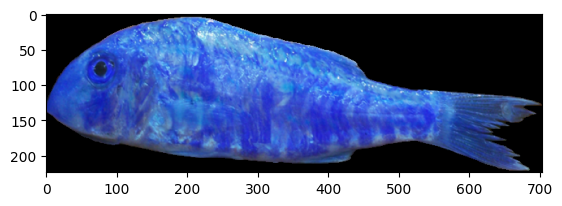

ID: 1
Name: Cyprinus rubrofuscus
Species ID: 029ddc0f-885b-4e85-8f1e-4c85d41269fc
Distance: 0.527
Accuracy: 100.00%
----------------------------------------


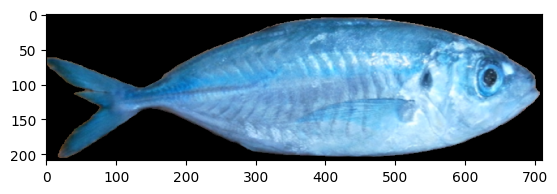

ID: 1
Name: Selar crumenophthalmus
Species ID: 56ac4a1a-92bb-424c-9aa4-e0a401905306
Distance: 0.708
Accuracy: 93.33%
----------------------------------------
ID: 2
Name: Caranx crysos
Species ID: 2ec05106-3fe8-47a8-a017-d8c8ebd03a60
Distance: 0.594
Accuracy: 6.67%
----------------------------------------


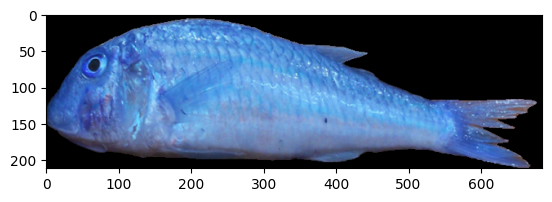

ID: 1
Name: Carassius auratus
Species ID: 669904c9-f15b-412e-82f9-5edbc4517e99
Distance: 0.217
Accuracy: 66.67%
----------------------------------------
ID: 2
Name: Mugil cephalus
Species ID: 83b209fb-9f06-4858-a236-fb19f4812742
Distance: 0.109
Accuracy: 6.67%
----------------------------------------
ID: 3
Name: Ictiobus bubalus
Species ID: 1c083a75-11bb-43dd-8d4f-881d00a58ff7
Distance: 0.090
Accuracy: 6.67%
----------------------------------------
ID: 4
Name: Bagre marinus
Species ID: f96cc087-6fd2-4545-b809-2be5dde5be4e
Distance: 0.065
Accuracy: 6.67%
----------------------------------------
ID: 5
Name: Menticirrhus americanus
Species ID: a46c0b27-8afe-46da-ad6e-815ea08bff4b
Distance: 0.061
Accuracy: 6.67%
----------------------------------------
ID: 6
Name: Barbonymus gonionotus
Species ID: 1c656b3a-9753-4f0b-931a-429ef79594ff
Distance: 0.059
Accuracy: 6.67%
----------------------------------------


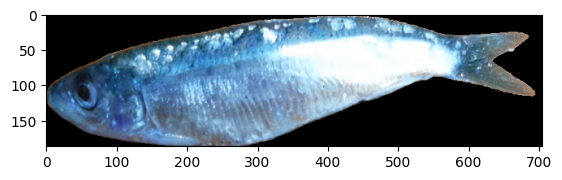

ID: 1
Name: Clupea harengus
Species ID: 4ccada1b-6c50-4ee7-bf4f-b80fd58f8fbb
Distance: 0.724
Accuracy: 100.00%
----------------------------------------


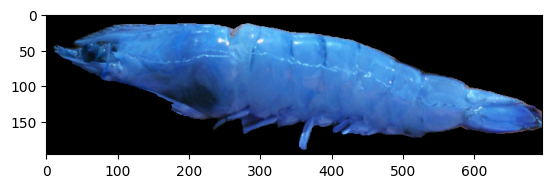

ID: 1
Name: Clarias batrachus
Species ID: b8a2390f-42c8-4a40-9a9d-f2f43051d68b
Distance: 0.709
Accuracy: 66.67%
----------------------------------------
ID: 2
Name: Clarias gariepinus
Species ID: 64ea6bfe-292d-4be6-99ca-13320b4e44a8
Distance: 0.726
Accuracy: 33.33%
----------------------------------------


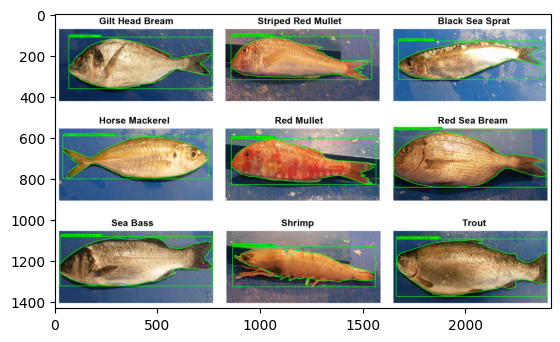

In [ ]:
# fish_bgr_np = cv2.imread(fish_path)
# visulize_img_bgr = fish_bgr_np.copy()

# visulize_img_rgb = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)
# visulize_img = copy.deepcopy(visulize_img_rgb)


# face_boxes = face_detector.predict(visulize_img_rgb)[0]

# for box in face_boxes:
#   box.draw_label(visulize_img, "Face")
#   box.draw_box(visulize_img)
# plt.imshow(visulize_img)
# plt.show()

# Get a list of all image files in the extracted_images directory
image_files = glob.glob(os.path.join(extract_dir, '*.jpg')) # You can add other image extensions if needed

for image_path in image_files:
    print(f"Processing image: {image_path}")
    fish_bgr_np = cv2.imread(image_path)
    if fish_bgr_np is None:
        print(f"Could not read image: {image_path}")
        continue

    visulize_img_bgr = fish_bgr_np.copy()
    visulize_img_rgb = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)
    visulize_img = copy.deepcopy(visulize_img_rgb)

    boxes = detector.predict(visulize_img_rgb)[0]

    for box in boxes:
      cropped_fish_bgr = box.get_mask_BGR()
      cropped_fish_rgb = box.get_mask_RGB()
      segmented_polygons = segmentator.predict(cropped_fish_bgr)[0]

      croped_fish_mask = segmented_polygons.mask_polygon(cropped_fish_rgb)

      segmented_polygons.move_to(box.x1, box.y1)
      segmented_polygons.draw_polygon(visulize_img)

      classification_result = classifier.batch_inference([cropped_fish_bgr])[0]

      label = f"{classification_result[0]['name']} | {round(classification_result[0]['accuracy'], 3)}" if len(classification_result) else "Not Found"
      box.draw_label(visulize_img, label)
      box.draw_box(visulize_img)

      print(50 * "=")
      plt.imshow(croped_fish_mask)
      plt.show()
      print_fish_data(classification_result)

    plt.imshow(visulize_img)
    plt.title(f"Processed Image: {os.path.basename(image_path)}")
    plt.show()

# FU

In [ ]:
import time
import cv2

# Image Load
face_bgr_np = img = cv2.imread(face_path)
face_rgb_np = cv2.cvtColor(face_bgr_np, cv2.COLOR_BGR2RGB)

fish_bgr_np = cv2.imread(fish_path)
fish_rgb_np = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)

times_array = []
for _ in range(3):
  start_time_complex = time.time()
  print(20 * "=")
  start_time = time.time()
  face_boxes = face_detector.predict(face_bgr_np)[0]
  end_time = time.time()
  print(f"Face detection time: {end_time - start_time:.4f} seconds")

  start_time = time.time()
  boxes = detector.predict(fish_bgr_np)[0]
  end_time = time.time()
  print(f"Fish detection time: {end_time - start_time:.4f} seconds")

  # Обработка каждого объекта
  for box in boxes:
      cropped_fish_bgr = box.get_mask_BGR()

      # Segmentation
      start_time = time.time()
      segmented_polygons = segmentator.predict(cropped_fish_bgr)[0]
      end_time = time.time()
      print(f"Segmentation time: {end_time - start_time:.4f} seconds")

      # Classification
      start_time = time.time()
      classification_result = classifier.batch_inference([cropped_fish_bgr])[0]
      end_time = time.time()
      print(f"Classification time: {end_time - start_time:.4f} seconds")
  times_array.append(time.time() - start_time_complex)

print(f"Average time: {sum(times_array)/len(times_array)}")

Face detection time: 0.1803 seconds
Fish detection time: 0.4544 seconds
Segmentation time: 0.4711 seconds
Classification time: 0.2754 seconds
Segmentation time: 0.4623 seconds
Classification time: 0.2520 seconds
Segmentation time: 0.4918 seconds
Classification time: 0.2591 seconds
Segmentation time: 0.4691 seconds
Classification time: 0.2480 seconds
Segmentation time: 0.4677 seconds
Classification time: 0.2490 seconds
Segmentation time: 0.4641 seconds
Classification time: 0.2569 seconds
Segmentation time: 0.4637 seconds
Classification time: 0.2499 seconds
Segmentation time: 0.4614 seconds
Classification time: 0.2566 seconds
Segmentation time: 0.4759 seconds
Classification time: 0.2454 seconds
Face detection time: 0.1666 seconds
Fish detection time: 0.4530 seconds
Segmentation time: 0.4584 seconds
Classification time: 0.3186 seconds
Segmentation time: 0.7134 seconds
Classification time: 0.3680 seconds
Segmentation time: 0.7144 seconds
Classification time: 0.3782 seconds
Segmentation tim

## Face detection time execution test without postprocessing

In [ ]:
BATCH_SIZE = 10
start_time = time.time()
face_detector.model(torch.randn(BATCH_SIZE,3,640,640))
print(f"Mean face detection total time (Batch): {(time.time() - start_time)} seconds")

Mean face detection total time (Batch): 2.254533052444458 seconds


## Fish detection time execution test without postprocessing

In [ ]:
BATCH_SIZE = 1
start_time = time.time()
detector.model(torch.randn(BATCH_SIZE,3,640,640))
print(f"Mean fish detection total time (Batch): {(time.time() - start_time)} seconds")


Mean fish detection total time (Batch): 0.9071292877197266 seconds


## Fish Segmentation time execution test without postprocessing

In [ ]:
BATCH_SIZE = 5
start_time = time.time()
segmentator.model(torch.randn(BATCH_SIZE,3,416,416))
print(f"Fish segmentation total time (Batch): {(time.time() - start_time)} seconds")

Fish segmentation total time (Batch): 6.364283084869385 seconds


## Fish Classification time execution test without postprocessing

In [ ]:
BATCH_SIZE = 5
start_time = time.time()
classifier.model(torch.randn(BATCH_SIZE,3,224,224))
print(f"Fish Classification total time (Batch): {(time.time() - start_time)} seconds")

Fish Classification total time (Batch): 0.8254907131195068 seconds


# Task
Process the images in the `extracted_images` folder to crop the fish and remove the background, saving the results to a new folder.

## Create output directory

### Subtask:
Create a new folder to save the processed images.


**Reasoning**:
Define the output directory name and create the directory.



In [ ]:
output_dir = "processed_images"
os.makedirs(output_dir, exist_ok=True)
print(f"Created output directory: {output_dir}")

Created output directory: processed_images


## Iterate through images

### Subtask:
Loop through each image in the `extracted_images` folder.


**Reasoning**:
Get a list of image files in the extracted_images directory and iterate through them, printing the filename for each.



## Perform detection and segmentation

### Subtask:
For each image, use the detector and segmentator models to get the fish bounding boxes and segmentation masks.


**Reasoning**:
Read the image, convert to RGB, predict bounding boxes with the detector, iterate through boxes, get the cropped BGR image, and predict segmentation masks for each cropped image.



## Apply mask and crop

### Subtask:
Apply the segmentation mask to the original image to remove the background and crop the image to the bounding box.


**Reasoning**:
Iterate through the processed data, read the original image, apply the segmentation mask to remove the background, crop the image to the bounding box, and store the processed image data.



**Reasoning**:
The previous command failed because the `FishialPolygon` object does not have a `polygon` attribute. I need to check the attributes of the `FishialPolygon` object to find the correct way to access the polygon points. Based on the previous successful execution, the polygon points should be accessed using `segmentation_mask.points`. I will fix the code to use the correct attribute and rerun the process to apply the segmentation mask and crop the images.



## Save processed images

### Subtask:
Save the processed images with transparent backgrounds to the new output folder.


**Reasoning**:
Iterate through the processed data, convert the processed images to RGBA, create unique filenames, and save the images to the output directory.



**Reasoning**:
The variable `processed_data` was not defined because the notebook state was reset. I need to re-run the previous steps that populate `processed_data`.



In [ ]:
image_files = glob.glob(os.path.join(extract_dir, '*.jpg'))

# processed_data = {} # No longer needed as we will save processed images directly

# Create output directory if it doesn't exist
output_dir = "processed_images"
os.makedirs(output_dir, exist_ok=True)
print(f"Created output directory: {output_dir}")


for image_path in image_files:
    print(f"Processing image: {os.path.basename(image_path)}")
    fish_bgr_np = cv2.imread(image_path)
    if fish_bgr_np is None:
        print(f"Could not read image: {image_path}")
        continue

    fish_rgb_np = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)

    boxes = detector.predict(fish_rgb_np)[0]

    # processed_data[image_path] = [] # No longer needed

    for i, box in enumerate(boxes): # Added enumerate to create unique filenames
        cropped_fish_bgr = box.get_mask_BGR()
        segmented_polygons = segmentator.predict(cropped_fish_bgr)[0]

        # processed_data[image_path].append({ # No longer needed
        #     'box': box,
        #     'segmentation_mask': segmented_polygons
        # })

        # --- Apply mask and crop ---
        original_bgr = cv2.imread(image_path)
        if original_bgr is None:
            print(f"Could not read image: {image_path}")
            continue

        original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

        # Get bounding box coordinates
        x1, y1, x2, y2 = int(box.x1), int(box.y1), int(box.x2), int(box.y2) # Corrected x2 coordinate

        # Create a blank mask image
        mask = np.zeros_like(original_rgb[:,:,0], dtype=np.uint8)

        # Draw the segmentation polygon onto the blank mask
        polygon_points = segmented_polygons.points
        if polygon_points is not None:
            # Move the polygon points to the original image coordinates
            moved_polygon_points = []
            for point in polygon_points:
                moved_polygon_points.append([point[0] + x1, point[1] + y1])

            # Reshape for cv2.fillPoly
            pts = np.array(moved_polygon_points, np.int32)
            pts = pts.reshape((-1, 1, 2))

            cv2.fillPoly(mask, [pts], 255)

        # Apply the mask to the original image
        masked_image = cv2.bitwise_and(original_rgb, original_rgb, mask=mask)

        # Crop the masked image to the bounding box
        cropped_image_rgb = masked_image[y1:y2, x1:x2]

        # --- Save processed images ---
        original_filename = os.path.splitext(os.path.basename(image_path))[0]

        # Convert RGB to RGBA
        h, w, _ = cropped_image_rgb.shape
        rgba_image = np.zeros((h, w, 4), dtype=np.uint8)
        rgba_image[:, :, :3] = cropped_image_rgb

        # Create an alpha channel based on the black background created by the mask
        # A pixel is transparent if its RGB values are all 0 (black background)
        gray_image = cv2.cvtColor(cropped_image_rgb, cv2.COLOR_RGB2GRAY)
        _, alpha_channel = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
        rgba_image[:, :, 3] = alpha_channel


        # Create a unique filename
        save_filename = f"{original_filename}_fish_{i+1}.png"
        save_path = os.path.join(output_dir, save_filename)

        # Save the RGBA image
        try:
            Image.fromarray(rgba_image, 'RGBA').save(save_path)
            print(f"Saved {save_path}")
        except Exception as e:
            print(f"Error saving {save_path}: {e}")

Created output directory: processed_images
Processing image: Vi201702.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201702_fish_1.png
Processing image: KU201702.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KU201702_fish_1.png
Processing image: K201803.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201803_fish_1.png
Processing image: R202101.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202101_fish_1.png
Processing image: H201708.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201708_fish_1.png
Processing image: K201712.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201712_fish_1.png
Processing image: S202116.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202116_fish_1.png
Processing image: PL201901.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/PL201901_fish_1.png
Processing image: VV202001.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VV202001_fish_1.png
Processing image: R202006.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202006_fish_1.png
Processing image: VA202004.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA202004_fish_1.png
Processing image: Vi202018.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202018_fish_1.png
Processing image: K201702.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201702_fish_1.png
Processing image: K201605.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201605_fish_1.png
Processing image: R202012.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202012_fish_1.png
Processing image: PL201902.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/PL201902_fish_1.png
Processing image: Vi202010.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202010_fish_1.png
Processing image: K201815.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201815_fish_1.png
Processing image: R202106.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202106_fish_1.png
Processing image: S202105.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202105_fish_1.png
Processing image: Vi202007.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202007_fish_1.png
Processing image: H201717.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201717_fish_1.png
Processing image: VV202003.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VV202003_fish_1.png
Processing image: K201817.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201817_fish_1.png
Processing image: VA201808.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201808_fish_1.png
Processing image: Vi201806.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201806_fish_1.png
Processing image: VA201703.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201703_fish_1.png
Processing image: VA201801.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201801_fish_1.png
Processing image: Vi201610.jpg
Processing image: K202005.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202005_fish_1.png
Processing image: S202109.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202109_fish_1.png
Processing image: VA202003.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA202003_fish_1.png
Processing image: R202102.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202102_fish_1.png
Processing image: S202129.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202129_fish_1.png
Processing image: VA201809.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201809_fish_1.png
Processing image: VA201811.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201811_fish_1.png
Processing image: S202108.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202108_fish_1.png
Processing image: K201612.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201612_fish_1.png
Processing image: K201608.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201608_fish_1.png
Processing image: Vi202009.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202009_fish_1.png
Processing image: VA201810.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201810_fish_1.png
Processing image: VA201607.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201607_fish_1.png
Processing image: K201715.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201715_fish_1.png
Processing image: R202003.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202003_fish_1.png
Processing image: R202107.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202107_fish_1.png
Processing image: S202125.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202125_fish_1.png
Processing image: S202114.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202114_fish_1.png
Processing image: K201601.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201601_fish_1.png
Processing image: VA201707.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201707_fish_1.png
Processing image: K201602.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201602_fish_1.png
Processing image: S202139.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202139_fish_1.png
Processing image: VA201704.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201704_fish_1.png
Processing image: S202130.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202130_fish_1.png
Processing image: Vi201708.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201708_fish_1.png
Processing image: S202128.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202128_fish_1.png
Processing image: K202010.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202010_fish_1.png
Processing image: VA201812.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201812_fish_1.png
Processing image: KN201705.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KN201705_fish_1.png
Processing image: VA201807.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201807_fish_1.png
Processing image: K201706.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201706_fish_1.png
Processing image: Vi201606.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201606_fish_1.png
Processing image: Vi201607.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201607_fish_1.png
Processing image: S202017.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202017_fish_1.png
Processing image: R202007.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202007_fish_1.png
Processing image: S202122.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202122_fish_1.png
Processing image: Vi202006.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202006_fish_1.png
Processing image: Vi201803.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201803_fish_1.png
Processing image: Vi201608.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201608_fish_1.png
Processing image: KN201701.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KN201701_fish_1.png
Processing image: S202112.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202112_fish_1.png
Processing image: k201603.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/k201603_fish_1.png
Processing image: Vi201804.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201804_fish_1.png
Processing image: S202010.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202010_fish_1.png
Processing image: Vi202013.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202013_fish_1.png
Processing image: S202004.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202004_fish_1.png
Processing image: K202008.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202008_fish_1.png
Processing image: S202111.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202111_fish_1.png
Processing image: R202002.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202002_fish_1.png
Processing image: K201614.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201614_fish_1.png
Processing image: S202137.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202137_fish_1.png
Processing image: K201703.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201703_fish_1.png
Processing image: K201613.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201613_fish_1.png
Processing image: Vi201807.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201807_fish_1.png
Processing image: S202003.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202003_fish_1.png
Processing image: S202103.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202103_fish_1.png
Processing image: VA201804.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201804_fish_1.png
Processing image: K201813.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201813_fish_1.png
Processing image: K201713.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201713_fish_1.png
Processing image: H201709.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201709_fish_1.png
Processing image: Vi202011.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202011_fish_1.png
Processing image: Vi201712.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201712_fish_1.png
Processing image: S202131.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202131_fish_1.png
Processing image: S202007.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202007_fish_1.png
Processing image: Vi201603.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201603_fish_1.png
Processing image: Avv201701.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Avv201701_fish_1.png
Processing image: K202009.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202009_fish_1.png
Processing image: K201607.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201607_fish_1.png
Processing image: S202013.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202013_fish_1.png
Processing image: Vi201706.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201706_fish_1.png
Processing image: K202006.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202006_fish_1.png
Processing image: S202008.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202008_fish_1.png
Processing image: Vi201705.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201705_fish_1.png
Processing image: Vi201713.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201713_fish_1.png
Processing image: S202136.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202136_fish_1.png
Processing image: PA202001.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/PA202001_fish_1.png
Processing image: H201704.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201704_fish_1.png
Processing image: Vi202012.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202012_fish_1.png
Processing image: K201802.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201802_fish_1.png
Processing image: VA201803.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201803_fish_1.png
Processing image: Vi201612.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201612_fish_1.png
Processing image: Vi201605.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201605_fish_1.png
Processing image: VA201701.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201701_fish_1.png
Processing image: K201816.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201816_fish_1.png
Processing image: KU201701.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KU201701_fish_1.png
Processing image: S202101.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202101_fish_1.png
Processing image: S202110.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202110_fish_1.png
Processing image: Vi202014.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202014_fish_1.png
Processing image: VA201702.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201702_fish_1.png
Processing image: K201814.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201814_fish_1.png
Processing image: KU201704.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KU201704_fish_1.png
Processing image: S202126.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202126_fish_1.png
Processing image: S202002.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202002_fish_1.png
Processing image: Vi201802.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201802_fish_1.png
Processing image: S202107.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202107_fish_1.png
Processing image: Vi201613.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201613_fish_1.png
Processing image: Vi201701.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201701_fish_1.png
Processing image: VA202006.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA202006_fish_1.png
Processing image: KN201702.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KN201702_fish_1.png
Processing image: S202134.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202134_fish_1.png
Processing image: K201807.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201807_fish_1.png
Processing image: Vi202003.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202003_fish_1.png
Processing image: Vi202017.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202017_fish_1.png
Processing image: KU201703.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KU201703_fish_1.png
Processing image: H201714.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201714_fish_1.png
Processing image: R202108.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202108_fish_1.png
Processing image: K201708.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201708_fish_1.png
Processing image: H201706.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201706_fish_1.png
Processing image: R202103.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202103_fish_1.png
Processing image: H201711.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201711_fish_1.png
Processing image: PL201903.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/PL201903_fish_1.png
Processing image: VA201706.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201706_fish_1.png
Processing image: K201806.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201806_fish_1.png
Processing image: H201702.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201702_fish_1.png
Processing image: VA201802.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201802_fish_1.png
Processing image: R202004.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202004_fish_1.png
Processing image: H201701.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201701_fish_1.png
Processing image: K202003.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202003_fish_1.png
Processing image: K201810.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201810_fish_1.png
Processing image: R202105.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202105_fish_1.png
Processing image: R202109.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202109_fish_1.png
Processing image: Vi201704.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201704_fish_1.png
Processing image: Vi201805.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201805_fish_1.png
Processing image: H201716.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201716_fish_1.png
Processing image: S202123.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202123_fish_1.png
Processing image: S202127.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202127_fish_1.png
Processing image: Vi201602.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201602_fish_1.png
Processing image: K201705.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201705_fish_1.png
Processing image: S202138.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202138_fish_1.png
Processing image: NJ202001.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/NJ202001_fish_1.png
Processing image: K202002.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202002_fish_1.png
Processing image: S202104.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202104_fish_1.png
Processing image: VA202002.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA202002_fish_1.png
Processing image: VA201602.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201602_fish_1.png
Processing image: Vi202015.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202015_fish_1.png
Processing image: S202113.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202113_fish_1.png
Processing image: S202009.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202009_fish_1.png
Processing image: K201804.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201804_fish_1.png
Processing image: VA201805.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201805_fish_1.png
Processing image: S202124.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202124_fish_1.png
Processing image: R202001.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202001_fish_1.png
Processing image: S202006.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202006_fish_1.png
Processing image: VV202004.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VV202004_fish_1.png
Processing image: K201606.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201606_fish_1.png
Processing image: H201715.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201715_fish_1.png
Processing image: K201818.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201818_fish_1.png
Processing image: VA201604.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201604_fish_1.png
Processing image: S202001.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202001_fish_1.png
Processing image: VA201608.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201608_fish_1.png
Processing image: S202120.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202120_fish_1.png
Processing image: K201701.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201701_fish_1.png
Processing image: Vi201808.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201808_fish_1.png
Processing image: S202115.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202115_fish_1.png
Processing image: K201801.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201801_fish_1.png
Processing image: VA201705.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201705_fish_1.png
Processing image: S202119.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202119_fish_1.png
Processing image: PA202002.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/PA202002_fish_1.png
Processing image: Vi201604.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201604_fish_1.png
Processing image: K201611.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201611_fish_1.png
Processing image: Vi201709.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201709_fish_1.png
Processing image: K201711.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201711_fish_1.png
Processing image: H201707.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201707_fish_1.png
Processing image: Vi201703.jpg
Processing image: R202013.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202013_fish_1.png
Processing image: VV202002.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VV202002_fish_1.png
Processing image: Vi202004.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202004_fish_1.png
Processing image: K201707.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201707_fish_1.png
Processing image: K201710.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201710_fish_1.png
Processing image: S202102.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202102_fish_1.png
Processing image: S202117.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202117_fish_1.png
Processing image: Vi201711.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201711_fish_1.png
Processing image: KN201704.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KN201704_fish_1.png
Processing image: S202132.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202132_fish_1.png
Processing image: Vi202016.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202016_fish_1.png
Processing image: H201703.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201703_fish_1.png
Processing image: Vi201611.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201611_fish_1.png
Processing image: S202118.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202118_fish_1.png
Processing image: K202004.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202004_fish_1.png
Processing image: Vi202005.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202005_fish_1.png
Processing image: K202001.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202001_fish_1.png
Processing image: Vi202008.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202008_fish_1.png
Processing image: Vi201801.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201801_fish_1.png
Processing image: K201704.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201704_fish_1.png
Processing image: S202135.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202135_fish_1.png
Processing image: S202015.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202015_fish_1.png
Processing image: R202104.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202104_fish_1.png
Processing image: R202009.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202009_fish_1.png
Processing image: K201610.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201610_fish_1.png
Processing image: VA202001.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA202001_fish_1.png
Processing image: VA201605.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201605_fish_1.png
Processing image: VA201603.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201603_fish_1.png
Processing image: H201710.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201710_fish_1.png
Processing image: S202016.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202016_fish_1.png
Processing image: K201811.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201811_fish_1.png
Processing image: H201712.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201712_fish_1.png
Processing image: Vi201710.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201710_fish_1.png
Processing image: Vi202002.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202002_fish_1.png
Processing image: H201705.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201705_fish_1.png
Processing image: Vi201707.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201707_fish_1.png
Processing image: K201604.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201604_fish_1.png
Processing image: K201805.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201805_fish_1.png
Processing image: S202005.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202005_fish_1.png
Processing image: S202011.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202011_fish_1.png
Processing image: K201808.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201808_fish_1.png
Processing image: KN201703.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KN201703_fish_1.png
Processing image: S202133.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202133_fish_1.png
Processing image: H201713.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/H201713_fish_1.png
Processing image: K202007.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202007_fish_1.png
Processing image: K201809.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201809_fish_1.png
Processing image: P202001.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/P202001_fish_1.png
Processing image: K201714.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201714_fish_1.png
Processing image: K201812.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201812_fish_1.png
Processing image: Vi201609.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201609_fish_1.png
Processing image: R202008.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202008_fish_1.png
Processing image: K202102.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K202102_fish_1.png
Processing image: S202121.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202121_fish_1.png
Processing image: VA201601.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201601_fish_1.png
Processing image: K201609.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201609_fish_1.png
Processing image: R202005.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202005_fish_1.png
Processing image: K201709.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/K201709_fish_1.png
Processing image: S202014.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202014_fish_1.png
Processing image: VA201806.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201806_fish_1.png
Processing image: R202010.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202010_fish_1.png
Processing image: Vi201601.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi201601_fish_1.png
Processing image: S202012.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202012_fish_1.png
Processing image: R202011.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202011_fish_1.png
Processing image: R202110.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202110_fish_1.png
Processing image: VA202005.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA202005_fish_1.png
Processing image: KU201705.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/KU201705_fish_1.png
Processing image: S202018.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202018_fish_1.png
Processing image: VA201606.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/VA201606_fish_1.png
Processing image: S202106.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/S202106_fish_1.png
Processing image: R202015.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/R202015_fish_1.png
Processing image: Vi202001.jpg


/tmp/ipython-input-1256983172.py:88: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(rgba_image, 'RGBA').save(save_path)


Saved processed_images/Vi202001_fish_1.png
